# Advanced Lane Finding Project
## The goals / steps of this project are the following:
* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.<br />


In [2]:
#First the imports
import numpy as np
import cv2
import glob #it didn't work with me for some reason in the workspace but let's keep it just in case
import matplotlib.pyplot as plt
import matplotlib.image as mpimg #i will use the plotting method of the previous project

%matplotlib inline
#%matplotlib qt


## Now I'll compute the camera calibration using chessboard images

In [3]:

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
nx=9 #number of corners horizontally 
ny=6 #number of corners vertically
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.

objpoints = [] # 3d points in real world space, but the z coordinate has to always be zero, because the pictures were taken on a flat surface
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images

images=[]
for i in range(1,21):
    s='/home/workspace/CarND-Advanced-Lane-Lines/camera_cal/calibration'+str(i)+'.jpg'
    #print(s)
    img=mpimg.imread(s)
    images.append(img)
    
    #plt.imshow(img)
#print(len(images))

# Step through the list and search for chessboard corners

for img in images:
    #First transform to grayScale because this is what the cv2 calibration functions deal with
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp) 
        imgpoints.append(corners)
        #print(corners)

        # Draw and display the corners -Not an important step, just for testing and visualization
        img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        #plt.imshow(img)
        
#NOW i have the corners of all the distorted images, it's time to calculate the calibration matrices

gray=cv2.cvtColor(images[1],cv2.COLOR_BGR2GRAY)
ret,mtx,dist,rvecs,tvecs=cv2.calibrateCamera(objpoints,imgpoints,gray.shape[::-1],None,None)

#Now that i have the matrices i want to test the undistortion correction, so i'll try it on one of the test images
# The output of my trials will be saved in this path ''
"""
testImageInput=mpimg.imread('/home/workspace/CarND-Advanced-Lane-Lines/camera_cal/calibration10.jpg')
testImageOutput= cv2.undistort(testImageInput,mtx,dist,None,mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(testImageInput)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(testImageOutput)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

mpimg.imsave('/home/workspace/CarND-Advanced-Lane-Lines/test_images/undistort-output.jpg',testImageOutput )
"""
#Now that the testing worked fine, it means we have a good distortion correction matrices
#Each time i want to undistort a Frame, i call the cv2.undistort(frameImage,mtx,dist,None,mtx) and it returns
#the undistorted frame
#NOW let's head to the next step,Color Space transformation


"\ntestImageInput=mpimg.imread('/home/workspace/CarND-Advanced-Lane-Lines/camera_cal/calibration10.jpg')\ntestImageOutput= cv2.undistort(testImageInput,mtx,dist,None,mtx)\n\nf, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))\nf.tight_layout()\nax1.imshow(testImageInput)\nax1.set_title('Original Image', fontsize=50)\nax2.imshow(testImageOutput)\nax2.set_title('Undistorted Image', fontsize=50)\nplt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)\n\nmpimg.imsave('/home/workspace/CarND-Advanced-Lane-Lines/test_images/undistort-output.jpg',testImageOutput )\n"

## Now transform images into a suitable Color Space

In [4]:
#I'm going to transform the images into HLS: Hue, Light, Saturation Color Space because i'm expecting the images
#to be in difficult light conditions, so if we exclude the Light from HLS, we should find it easy to know the
# color of objects in the image
#Note to self: i made this step before the perspective transform because i just thought to transform a part of the
#image that's already undistorted and in binary form, is a nicer thing to do.. idk..


#Basically i'm going to get the gray scale,and the S channel from the HSL space and combine them to form a binray image

#First upload all the images 
testImages=[]
testImages.append(mpimg.imread('/home/workspace/CarND-Advanced-Lane-Lines/test_images/straight_lines1.jpg'))
testImages.append(mpimg.imread('/home/workspace/CarND-Advanced-Lane-Lines/test_images/straight_lines2.jpg'))

for i in range(1,7):
    s='/home/workspace/CarND-Advanced-Lane-Lines/test_images/test'+str(i)+'.jpg'
    #print(s)
    img=mpimg.imread(s)
    testImages.append(img)
    
#print(len(testImages))

def get_abs_mag_dir_binary(image, abs_thresh=(0, 255),mag_thresh=(0, 255),dir_thresh=(0, np.pi/2),sobel_kernel=3):
    
    ###First The magnitude part
    
    #First grayScale
    gray=cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    #Get the "derivative" in the x direction
    sobelx=cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=sobel_kernel)
    sobely=cv2.Sobel(gray,cv2.CV_64F, 0,1,ksize=sobel_kernel)
    
    #idk if getting the mag is better or if getting sobelx only is better, but will try out everything, so let's see 
    mag= np.sqrt((sobelx**2)+(sobely**2))
    magScaled= np.uint8(mag*255/np.max(mag))
    
    magBinaryOutput= np.zeros_like(magScaled)
    magBinaryOutput[(magScaled>=mag_thresh[0]) & (magScaled<=mag_thresh[1])]=1
    
    
    ##Second For the Direction part
    
    sobelx_abs=np.absolute(sobelx)
    sobely_abs=np.absolute(sobely)  
    
    
    direction=np.arctan2(sobely_abs,sobelx_abs) 
    
    dirBinaryOutput=np.zeros_like(direction)
    dirBinaryOutput[(direction>=dir_thresh[0]) & (direction<=dir_thresh[1])]=1 
    
    #Finally for the ABSOLUTE PART
    abs_scaled =np.uint8(255*sobelx_abs/np.max(sobelx_abs)) 
    absBinary= np.zeros_like(abs_scaled)
    absBinary[(abs_scaled>= abs_thresh[0]) & (abs_scaled <= abs_thresh[1])] =1
    
    #NOW COMBINE
    combined = np.zeros_like(dirBinaryOutput)
    #combined[(absBinary == 1) |((magBinaryOutput == 1) & (dirBinaryOutput == 1))] = 1
    #combined[(absBinary == 1) &(  (dirBinaryOutput == 1))] = 1
    combined[(absBinary == 1) |((magBinaryOutput == 1) )] = 1


    
    
    return absBinary


def get_s_binary(img, s_thresh=(0, 255)):
    
    hls=cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
    #I remember from the quizes and my trials that the S channel was the best in different lighting conditions so..
    s=hls[:,:,2]
    

    binary_output=np.zeros_like(s)
    binary_output[(s>s_thresh[0]) & (s<=s_thresh[1])]=1 
    
    
    return binary_output

#TESTING
"""
outt=get_abs_mag_dir_binary(testImages[6],abs_thresh=(20,100),mag_thresh=(200, 255),dir_thresh=(0.7, 1.3))
#outt=get_s_binary(testImages[6],s_thresh=(165,255))
#plt.imshow(outt)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(testImages[6])
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(outt, cmap='gray')
ax2.set_title('Thresholded Magnitude', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
"""



#Now let's define a function that transforms each frame/image into my combined binary fram/image
def getCombinedBinary(image,Abs_Thresh=(15,100),Mag_Thresh=(100, 255),Dir_Thresh=(0.7, 1.3),S_Thresh=(170,255),Sobel_Kernel=3):
    """
    #s_thresh=(170, 255), sx_thresh=(20, 100)
    #First grayScale
    gray=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    #Get the "derivative" in the x direction
    sobelx=cv2.Sobel(gray,cv2.CV_64F, 1,0,ksize=sobel_kernel)
    sobely=cv2.Sobel(gray,cv2.CV_64F, 0,1,ksize=sobel_kernel)
    
    #idk if getting the mag is better or if getting sobelx only is better, but will try out everything, so let's see 
    mag= np.sqrt((sobelx**2)+(sobely**2))
    magScaled= np.uint8(mag*255/np.max(mag))
    
    magBinaryOutput= np.zeros_like(mag_scaled)
    magBinaryOutput[(mag_scaled>=mag_thresh[0]) & (mag_scaled<=mag_thresh[1])]=1
    """
    outt1=get_abs_mag_dir_binary(image,abs_thresh=Abs_Thresh,mag_thresh=Mag_Thresh,dir_thresh=Dir_Thresh,sobel_kernel=Sobel_Kernel)
    outt2=get_s_binary(image,s_thresh=S_Thresh)
    
    #combined = np.dstack(( np.zeros_like(outt1), outt1, outt2)) * 255
    
    #E7NA WE2FNA YA YOMNA W 3ANDK MOSHKELA FE EL OUTPUT BYTLA3 FE BO23A BEL3ARD KEDA+ MSH 3ARFEN NE3ML DSTACK W HYA SHAKLAHA MOHEMA BTW 
    combined = np.zeros_like(outt2)
    combined[((outt1 == 1) | (outt2 == 1))] = 1

    return combined
"""
#TESTING
#FIRST FIX THE IMAGE DISTORTION
image_=cv2.undistort(testImages[5],mtx,dist,None,mtx)
    
outt=getCombinedBinary(image_)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(testImages[5])
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(outt, cmap='gray')
ax2.set_title('Thresholded Magnitude', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
   
"""
#Now we test this pipeline on the 8 images in the examples directory


"\n#TESTING\n#FIRST FIX THE IMAGE DISTORTION\nimage_=cv2.undistort(testImages[5],mtx,dist,None,mtx)\n    \noutt=getCombinedBinary(image_)\nf, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))\nf.tight_layout()\nax1.imshow(testImages[5])\nax1.set_title('Original Image', fontsize=50)\nax2.imshow(outt, cmap='gray')\nax2.set_title('Thresholded Magnitude', fontsize=50)\nplt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)\n   \n"

## Now time for Perspective Transform

In [5]:
#Let's pick an area that most probably represents a rectangle in the real world 
#Let's define a function for transforming each image
def persp_trans(img):
    img_size=(img.shape[1],img.shape[0])
     
    src=np.float32(
        [[195,img.shape[0]],   #Low_Left
         [1140,img.shape[0]],   #Low_Right
         [550,470],            #Up_Left
         [720,470]])           #Up_Right
    
    offset=300
    
    dst=np.float32(
        [[offset,img.shape[0]],
         [img.shape[1]-offset,img.shape[0]],
         [offset,offset],
         [img.shape[1]-offset,offset]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped, M, Minv
"""
#TEST
pres_trans_output=persp_trans(outt)
plt.imshow(pres_trans_output)
""" 

'\n#TEST\npres_trans_output=persp_trans(outt)\nplt.imshow(pres_trans_output)\n'

### Now we (suppose that we) have a reasonable lane detection, curvature calculation, pos estimation let's warp the image back and do the visual supporting to each frame

In [6]:
"""
def unwarp(undist,warped, left_fitx, right_fitx, ploty,Minv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    #print(pts_left)
    #print(pts_right)
    #print(pts)
    vertices = np.array([[(left_fitx[0],ploty[0]),(left_fitx[0],ploty[0]), (right_fitx[-1],ploty[-1]),(right_fitx[-1],ploty[-1])]], dtype=np.int32)
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, vertices, (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0]), flags=cv2.INTER_LINEAR) 
    # Combine the result with the original image
    #cv2.addWeighted(initial_img, α, img, β, γ)
    #print(newwarp.shape[0],undist.shape[0])
    #print(newwarp.shape[1],undist.shape[1])
    #print(newwarp.shape[2]) #9
    print(Minv)
    #print(undist.shape[2]) #3
    #newwarp=cv2.cvtColor(newwarp,cv2.COLOR_BGR2GRAY)
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    plt.imshow(result)
    return result
    
"""

def unwarp(undist,warped,left_fitx,right_fitx,ploty,Minv):
    print('to2',warped.shape[0])
    print('to2',warped.shape[1])
    print('to2',warped.shape[2])

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    plt.imshow(result)
    return result


## Now let's apply our algorithms to detect the lane lines
### First the histogram peaks, the window search

In [7]:
def find_lane_pixels(img):
    pres_trans_output=img/255
    bottom_half=pres_trans_output[img.shape[0]//2:,:]
    
    histogram=np.sum(bottom_half,axis=0)
    
    out_img = np.dstack((img, img, img))
    #out_img=img
    
    #Now pick a point to in the middle of the left half and the right half as a starting point
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    for_veh_pos=[]
    for_veh_pos.append(midpoint)
    for_veh_pos.append(leftx_base)
    for_veh_pos.append(rightx_base)
    
    #HYPERPARAMETERS
    nwindows=9
    margin=100
    minpix=50
    window_height = np.int(img.shape[0]//nwindows)
    
    #Determine the nonzero pixels in the whole wraped binary image  
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    #Update the current x coordinate of the center of the window  
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    #Now iterate for each window
    for window in range(nwindows):
        #First identify the boundaries of each window
        
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        
        win_xleft_low = leftx_current-margin
        win_xleft_high = leftx_current+margin
        win_xright_low = rightx_current-margin
        win_xright_high = rightx_current+margin
        """
        print(win_y_low)
        print(win_y_high)
        print(win_xleft_low)
        print(win_xleft_high)
        print(win_xright_high)
        print(win_xright_low)
        """
        """
        #Now draw rectangles, but this is just for visualization it's not important for the pipeline
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        """
        #Extract the nonzero points which are inside each window (simple geometry)#
        good_left_inds = ((nonzeroy>=win_y_low)&(nonzeroy<win_y_high)&(nonzerox>=win_xleft_low)&(nonzerox<win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy>=win_y_low)&(nonzeroy<win_y_high)&(nonzerox>=win_xright_low)&(nonzerox<win_xright_high)).nonzero()[0]
        #Now this is like a list for each window, append it to an integration array
        
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        #Recenter window if the number of nonzero pixels found inside of it is larger than minpix(let's tune this part as well)#
        
        if len(good_left_inds)> minpix :
            leftx_current=np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds)>minpix :
            rightx_current=np.int(np.mean(nonzerox[good_right_inds]))
        
    #Now this is the end of our iteration over each window
    #Let's combine all the lane pixles found into one integration list
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully,, i kept this because
        #If no pixles were found (just mere error handling)
        pass
    
    #Now that we have a right and a left list that represent the lane's pixles(in a 0 or 1 form allover the nonzero arrays as i understood)#
    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return leftx, lefty, rightx, righty, out_img,for_veh_pos


        
    
    
    
    



    
#TEST
#plt.plot(histo(pres_trans_output)) #this is when it only returned a histogram plot 
#leftx, lefty, rightx, righty, out_img=find_lane_pixels(pres_trans_output)
#outtt=np.dstack((np.zeros_like(out_img),out_img,pres_trans_output))
#out_img[lefty, leftx] = [255, 0, 0]
#out_img[righty, rightx] = [0, 0, 255]

#plt.imshow(out_img)


##  Now let's apply our fitting polynomial algorithm and calculate the curvature in the pixel space

In [8]:
def fit_poly(img,undist,Minv):
    #First of course call the window algorithm function to determined the pixles
    leftx, lefty, rightx, righty, out_img,for_veh_pos=find_lane_pixels(img)
    
    #As we can see, it returns lists of points which are supposed to form a curve, so let's fit a curve to them
    #Let's assume the equation is of degree 2 
    left_fit = np.polyfit(lefty,leftx,2)
    right_fit = np.polyfit(righty,rightx,2)
    
    #now forget about the pixels we got before -for a while-, now we have a curve!
    #Let's generate y values for this curve
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    
    #Let's get the correspoinding x values of each curve 
    #Simple algebra this is done by substituting the ploty (y values) in the curve's equation
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        #If that happen's let's assume the coefficients ourselves to be ones
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
        
        
    #This part is for visualization it's not important for the pipeline
    #out_img[lefty, leftx] = [255, 0, 0]   #RED LEFT CURVE
    #out_img[righty, rightx] = [0, 0, 255] #BLUE RIGHT CURVE

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    
    #
    #
    #
    #
    
    #NOW for the curve calculation part
    """
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    #ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    
    y_eval = np.max(ploty)
    
    #left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    #right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
   
    
    left_curverad = ((1+(2*left_fit[0]*y_eval*ym_per_pix+left_fit[1])**2))**1.5/np.absolute(2*left_fit[0])
    right_curverad = ((1+(2*right_fit[0]*y_eval*ym_per_pix+right_fit[1])**2))**1.5/np.absolute(2*right_fit[0])
    """
    
    # Define conversions in x and y from pixels space to meters
    my = 30/700 # meters per pixel in y dimension
    mx = 3.7/600 # meters per pixel in x dimension
    
    #ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    
    #y_eval = np.max(ploty)*my
    #print(y_eval)
    y_eval=700
    
    #Let's use the student's approach
    
    #x= mx / (my ** 2) *a*(y**2)+(mx/my)*b*y+c
    
    left_fit[0]= mx/(my**2)*left_fit[0]
    right_fit[0]=mx/(my**2)*right_fit[0]
    
    left_fit[1]=(mx/my)*left_fit[1]
    right_fit[1]=(mx/my)*right_fit[1]
    
    #Now we have the curves in the real world dimensions, we can substitute in the curvature equation with ease
    left_curverad = (1+(2*left_fit[0]*y_eval+left_fit[1])**2)**(3/2)/ (np.absolute(2*left_fit[0]))
    right_curverad =  (1+(2*right_fit[0]*y_eval+right_fit[1])**2)**(3/2)/ (np.absolute(2*right_fit[0])) 
    
    
    print(left_curverad,'m', right_curverad,'m')
    
    #NOW let's try to calculate the vehicles position with respect to the lane's center
    lanes_mid=(for_veh_pos[1]+for_veh_pos[2])//2
    frame_mid=for_veh_pos[0]
    veh_pos_pixel= lanes_mid-frame_mid
    veh_pos_m = veh_pos_pixel*mx
    if veh_pos_pixel>0 : #positive this means the vehicle is shifted left (because the lanes_mid is larger)
        print('vehicle approximately shifted left with',veh_pos_m,'m')
    
    elif veh_pos_pixel<0: #negative this means the vehicle is shifted right
        print('vehicle approximately shifted right',veh_pos_m,'m')
        
    elif veh_pos_pixel == 0: #Centered correctly
        print('vehicle approximately centered')
        
        
    
    
    
    #NOW TO UNWARP THE FRAAAAAAME YA RAB
    unwarpped=unwarp(undist,out_img, left_fitx, right_fitx, ploty,Minv)

        
    

    return unwarpped

"""
##Testing
out_img = fit_poly(pres_trans_output)

plt.imshow(out_img)
   """ 
    
    

'\n##Testing\nout_img = fit_poly(pres_trans_output)\n\nplt.imshow(out_img)\n   '

## Pipeline to test images  

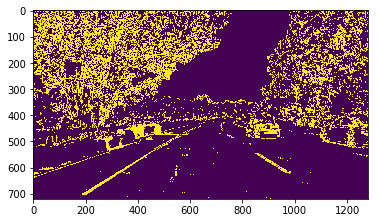

In [9]:
#Remember the test images were uploaded in the Color Space cell
#First the distortion and the color space 

testtest=testImages[6]

#FIRST FIX THE IMAGE DISTORTION
image_=cv2.undistort(testtest,mtx,dist,None,mtx)

binImg=getCombinedBinary(image_)

plt.imshow(binImg)

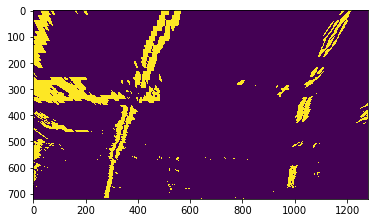

In [10]:
pres,M_,Minv_=persp_trans(binImg)
plt.imshow(pres)

4255.16596371 m 5524.55848325 m
vehicle approximately shifted left with 0.1665 m
to2 720
to2 1280
to2 3


error: /feedstock_root/build_artefacts/opencv_1496434080029/work/opencv-3.2.0/modules/core/src/matrix.cpp:1104: error: (-215) cn <= 4 in function scalarToRawData


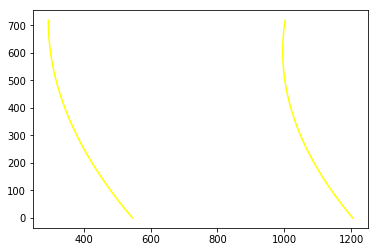

In [11]:
outimg = fit_poly(pres,image_,Minv_)

plt.imshow(outimg)
